# Proyecto 1
## Detección de ataques

In [1]:
import os.path

import pandas as pd
from pandas_profiling import ProfileReport

import utils

In [20]:
generate_reports: bool = False
generate_dfs: bool = True

In [3]:
df = pd.read_csv("dataset/sampled_df.csv")

df.shape

(400000, 50)

## Preprocessing

### Remove unnecesary variables

#### Drop constants

In [4]:
# CONSTANTS 
constants = [
    'BIFLOW_DIRECTION',
    'FIREWALL_EVENT',
    'FLOW_ACTIVE_TIMEOUT',
    'FLOW_INACTIVE_TIMEOUT',
    'FRAME_LENGTH',
    'MAX_IP_PKT_LEN',
    'MIN_IP_PKT_LEN',
    'SAMPLING_INTERVAL',
    'DIRECTION',
    'OOORDER_IN_PKTS',
    'OOORDER_OUT_PKTS',
]

# DIRECTION, OOORDER_IN_PKTS and OOORDER_OUT_PKTS has 99%> zero values, so it will be considered a constant.

In [5]:
# Drop constants from dataframe
df = df.drop(constants, axis=1)
len(df.columns.values)

39

#### Drop unique values

In [6]:
# UNIQUE
unique_vars = ['FLOW_ID', 'TOTAL_FLOWS_EXP']

In [7]:
df = df.drop(unique_vars, axis=1)
len(df.columns.values)

37

#### DROP IPS

In [8]:
df = df.drop(["IPV4_DST_ADDR", "IPV4_SRC_ADDR"], axis = 1)

#### DROP PROTOCOL COLUMN

In [9]:
df = df.drop(["PROTOCOL"], axis = 1)

#### Clean data from report

In [10]:
# Drop columns that almost everything is 0
df = df.drop(columns=["RETRANSMITTED_IN_BYTES", "RETRANSMITTED_IN_PKTS"], axis = 1)

In [11]:
df = df.drop(columns=["RETRANSMITTED_OUT_BYTES", "RETRANSMITTED_OUT_PKTS"], axis=1)

In [12]:
df = df.drop(columns=["TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_IN", "TCP_WIN_SCALE_IN", "TCP_WIN_SCALE_OUT", "SRC_TOS", "DST_TOS"], axis=1)

### Numerical preprocessing

#### Fix DST_TO_SRC_SECOND_BYTES column

In [13]:
# df["DST_TO_SRC_SECOND_BYTES"].apply(np.isreal)
DST_TO_SRC_SECOND_BYTES_INT_VALUES = list(filter(utils.is_int, df["DST_TO_SRC_SECOND_BYTES"]))
DST_TO_SRC_SECOND_BYTES_NON_INT_VALUES = list(filter(lambda x: not utils.is_int(x), df["DST_TO_SRC_SECOND_BYTES"]))

In [14]:
print("Correct int values: ", len(DST_TO_SRC_SECOND_BYTES_INT_VALUES))
print("Incorrect int values: ", len(DST_TO_SRC_SECOND_BYTES_NON_INT_VALUES))
print("Total values count: ", len(df["DST_TO_SRC_SECOND_BYTES"]))

Correct int values:  149229
Incorrect int values:  250771
Total values count:  400000


In [15]:
df_safe_clean = df.copy()

In [16]:
df["DST_TO_SRC_SECOND_BYTES"] = df["DST_TO_SRC_SECOND_BYTES"].apply(lambda x: int(x) if utils.is_int(x) else utils.normalize_dst_to_src_column(x))
df["DST_TO_SRC_SECOND_BYTES"].head()

21451     152
267016    624
366071    624
15805     676
471774    164
Name: DST_TO_SRC_SECOND_BYTES, dtype: int64

In [17]:
# Replace the 0 with 1
df["DST_TO_SRC_SECOND_BYTES"].replace({0: 1}, inplace=True)
df["DST_TO_SRC_SECOND_BYTES"].head()

21451     152
267016    624
366071    624
15805     676
471774    164
Name: DST_TO_SRC_SECOND_BYTES, dtype: int64

#### Fix SRC_TO_DST_SECOND_BYTES column

In [18]:
df["SRC_TO_DST_SECOND_BYTES"] = df["SRC_TO_DST_SECOND_BYTES"].apply(lambda x: int(x) if utils.is_int(x) else utils.normalize_dst_to_src_column(x))
df["SRC_TO_DST_SECOND_BYTES"].head()

21451      401
267016    1061
366071    1208
15805     1181
471774     216
Name: SRC_TO_DST_SECOND_BYTES, dtype: int64

### Second profile report

In [21]:
if not os.path.isfile("reports/profile-numerical.html") and generate_reports:
    ProfileReport(df, title="Profile after numerical preprocessing", minimal=True).to_file("reports/profile-numerical.html")

#### Reduce skew data

In [22]:
import numpy as np
from scipy.stats import skew

def reduce_skew(column, fn = np.log):
    print("Skew actual value for column ", column,": ",skew(df[column]))
    df[column].replace({0: 1}, inplace=True)
    df[column] = df[column].apply(fn)
    print("New value: ", skew(df[column]))

In [23]:
reduce_skew("SRC_TO_DST_SECOND_BYTES")
reduce_skew("DST_TO_SRC_SECOND_BYTES")
reduce_skew("OUT_BYTES")

Skew actual value for column  SRC_TO_DST_SECOND_BYTES :  320.7154777230601
New value:  0.17133112588941588
Skew actual value for column  DST_TO_SRC_SECOND_BYTES :  153.25839693427338
New value:  -0.636851195681089
Skew actual value for column  OUT_BYTES :  172.67135981096527
New value:  -0.6363745136998752


In [24]:
reduce_skew("IN_BYTES")
reduce_skew("IN_PKTS")
reduce_skew("OUT_PKTS")

Skew actual value for column  IN_BYTES :  359.59791956661246
New value:  0.17339820025748845
Skew actual value for column  IN_PKTS :  298.4540359811908
New value:  0.23175722783844802
Skew actual value for column  OUT_PKTS :  185.79565962655298
New value:  0.42723418701690524


### Correlation check

In [25]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = df.corr()

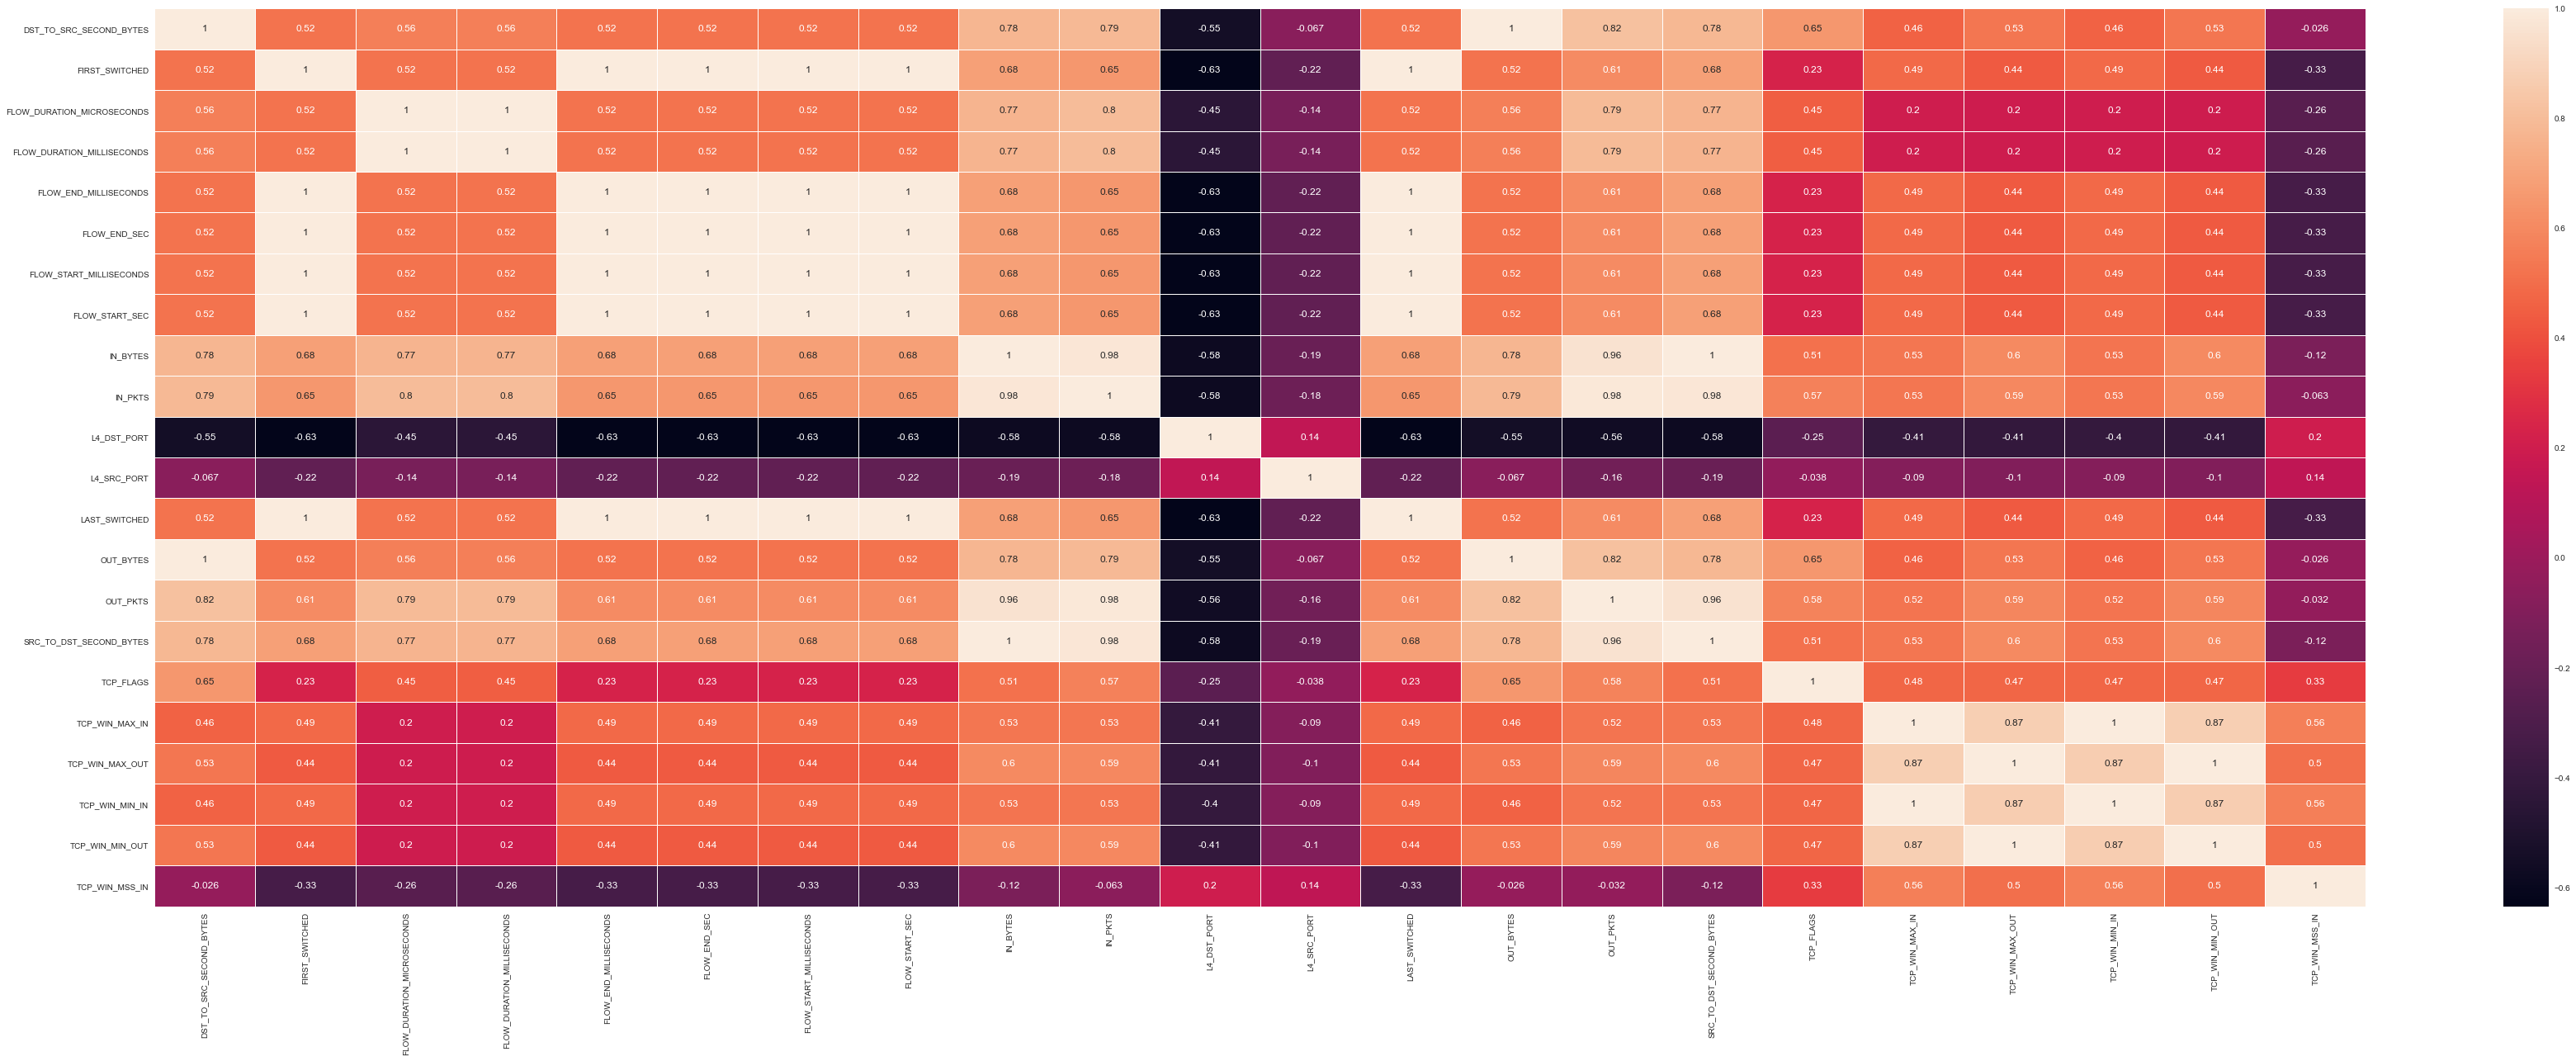

In [26]:
fig, ax = plt.subplots(figsize=(60,20)) 
sn.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

In [28]:
for column in corrMatrix:
        correl = []
        for index in corrMatrix[column].index:
            if column != index and abs(corrMatrix[column][index]) >= 0.75:
                correl.append((index, corrMatrix[column][index]))
        if len(correl) > 0:
            print("La columna ", column, " tuvo correlación con las columnas")
            print(correl)
            print("\n")

La columna  DST_TO_SRC_SECOND_BYTES  tuvo correlación con las columnas
[('IN_BYTES', 0.7765502418466362), ('IN_PKTS', 0.7887786330606839), ('OUT_BYTES', 0.9999995212291131), ('OUT_PKTS', 0.8157620792240889), ('SRC_TO_DST_SECOND_BYTES', 0.7765744501088228)]


La columna  FIRST_SWITCHED  tuvo correlación con las columnas
[('FLOW_END_MILLISECONDS', 0.9999999986556228), ('FLOW_END_SEC', 0.9999999986567297), ('FLOW_START_MILLISECONDS', 0.9999999999999286), ('FLOW_START_SEC', 1.0), ('LAST_SWITCHED', 0.9999999986567297)]


La columna  FLOW_DURATION_MICROSECONDS  tuvo correlación con las columnas
[('FLOW_DURATION_MILLISECONDS', 0.9999999999730909), ('IN_BYTES', 0.768136162832696), ('IN_PKTS', 0.7975528217265068), ('OUT_PKTS', 0.7912809927403887), ('SRC_TO_DST_SECOND_BYTES', 0.7681873747910086)]


La columna  FLOW_DURATION_MILLISECONDS  tuvo correlación con las columnas
[('FLOW_DURATION_MICROSECONDS', 0.9999999999730909), ('IN_BYTES', 0.7681358050511893), ('IN_PKTS', 0.79755231327353), ('OUT_PK

In [29]:
# Remove useless columns
columns_to_drop = [
    "DST_TO_SRC_SECOND_BYTES", "FLOW_END_MILLISECONDS", "FLOW_END_SEC", "FLOW_START_MILLISECONDS", "FLOW_START_SEC",
    "FLOW_DURATION_MICROSECONDS",
    "IN_BYTES",
    "TCP_WIN_MIN_OUT",
    "TCP_WIN_MIN_IN",
    "TCP_WIN_MAX_IN"
]
df = df.drop(columns=columns_to_drop, axis=1)

### Categorical variables preprocessing

#### Create PROTOCOL_MAP dummies

In [30]:
# Create the dummies
df = pd.get_dummies(df, columns=["PROTOCOL_MAP"])
df.head(3)

,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OUT_BYTES,OUT_PKTS,SRC_TO_DST_SECOND_BYTES,TCP_FLAGS,TCP_WIN_MAX_OUT,TCP_WIN_MSS_IN,L7_PROTO_NAME,LABEL,PROTOCOL_MAP_icmp,PROTOCOL_MAP_tcp,PROTOCOL_MAP_udp
21451,1618228297,210,1.386294,80,22683,1618228297,5.023881,1.098612,5.993961,31,27960,1410,HTTP,Denial of Service R-U-Dead-Yet,0,1,0
267016,1618225707,110020,2.484907,80,24276,1618225817,6.436150,2.484907,6.966967,24,114,0,HTTP,Denial of Service R-U-Dead-Yet,0,1,0
366071,1618227098,110056,2.639057,80,50684,1618227208,6.436150,2.484907,7.096721,24,114,0,HTTP,Denial of Service R-U-Dead-Yet,0,1,0


#### L7_PROTO_NAME dummies

In [31]:
df["L7_PROTO_NAME"].unique()

array(['HTTP', 'HTTP.TargusDataspeed', 'DNS', 'ICMP', 'Unknown',
       'BitTorrent', 'DNS.Google', 'TLS.Skype', 'TLS.Google',
       'TLS.Amazon', 'TLS', 'TLS.Microsoft', 'SMBv23', 'STUN.Messenger',
       'DNS.Microsoft365', 'DNS.OpenDNS', 'DNS.Amazon', 'DNS.Instagram',
       'SSH', 'TLS.Facebook', 'TLS.WhatsAppFiles', 'Google',
       'QUIC.Google', 'TLS.Microsoft365', 'TLS.Starcraft', 'Amazon',
       'DNS.Microsoft', 'TLS.Dropbox', 'SNMP', 'ICMP.Amazon',
       'TLS.Cloudflare', 'DNS.UbuntuONE', 'HTTP_Proxy.HTTP',
       'TLS.GoogleServices', 'HTTP.Microsoft', 'DNS.Dropbox', 'NTP',
       'DNS.Teams', 'DNS.Cloudflare', 'DNS.YouTube', 'HTTP.Apple',
       'DNS.GoogleServices', 'TLS.WindowsUpdate', 'DNS.Messenger',
       'TeamViewer', 'QUIC.YouTube', 'NFS', 'DNS.Facebook',
       'STUN.GoogleHangoutDuo', 'DNS.Apple', 'STUN.Skype', 'DNS.GMail',
       'DNS.Reddit', 'DNS.Webex', 'TLS.Tor', 'DNS.Spotify',
       'DNS.Telegram', 'DNS.Yahoo', 'TLS.GoogleDrive', 'DNS.WhatsApp',
       '

In [32]:
df["L7_PROTO_NAME"] = df["L7_PROTO_NAME"].map(lambda protocol: utils.lematize_protocol(protocol).upper())

In [33]:
print(df["L7_PROTO_NAME"].value_counts())

proto_name_dummies = df["L7_PROTO_NAME"].unique()

HTTP         201960
UNKNOWN      124054
DNS           27914
TLS           25542
ICMP           7105
              ...  
COLLECTD          1
BLOOMBERG         1
RX                1
WIREGUARD         1
TINC              1
Name: L7_PROTO_NAME, Length: 106, dtype: int64


In [34]:
df = pd.get_dummies(df, columns = ["L7_PROTO_NAME"])
df.head(3)

,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OUT_BYTES,OUT_PKTS,SRC_TO_DST_SECOND_BYTES,TCP_FLAGS,...,L7_PROTO_NAME_VIBER,L7_PROTO_NAME_VMWARE,L7_PROTO_NAME_VNC,L7_PROTO_NAME_WHATSAPPFILES,L7_PROTO_NAME_WHOIS-DAS,L7_PROTO_NAME_WIREGUARD,L7_PROTO_NAME_WSD,L7_PROTO_NAME_XBOX,L7_PROTO_NAME_XDMCP,L7_PROTO_NAME_ZABBIX
21451,1618228297,210,1.386294,80,22683,1618228297,5.023881,1.098612,5.993961,31,...,0,0,0,0,0,0,0,0,0,0
267016,1618225707,110020,2.484907,80,24276,1618225817,6.436150,2.484907,6.966967,24,...,0,0,0,0,0,0,0,0,0,0
366071,1618227098,110056,2.639057,80,50684,1618227208,6.436150,2.484907,7.096721,24,...,0,0,0,0,0,0,0,0,0,0


##### Remove PROTO_NAME dummies with less than 200 occurences

In [35]:
count = 0
for name in proto_name_dummies:
    column = f"L7_PROTO_NAME_{name}"
    if len(df[df[column] == 1]) < 200:
        df = df.drop(column, axis=1)
        print(f"Removed column: {column}")
        count += 1

print(f"Removed {count} columns.")


Removed column: L7_PROTO_NAME_SMBV23
Removed column: L7_PROTO_NAME_AMAZON
Removed column: L7_PROTO_NAME_SNMP
Removed column: L7_PROTO_NAME_HTTP_PROXY
Removed column: L7_PROTO_NAME_LDAP
Removed column: L7_PROTO_NAME_OPENVPN
Removed column: L7_PROTO_NAME_MEMCACHED
Removed column: L7_PROTO_NAME_MSSQL-TDS
Removed column: L7_PROTO_NAME_RTMP
Removed column: L7_PROTO_NAME_SIP
Removed column: L7_PROTO_NAME_REDIS
Removed column: L7_PROTO_NAME_FTP_DATA
Removed column: L7_PROTO_NAME_RTP
Removed column: L7_PROTO_NAME_APPLE
Removed column: L7_PROTO_NAME_IMAPS
Removed column: L7_PROTO_NAME_FTP_CONTROL
Removed column: L7_PROTO_NAME_RTSP
Removed column: L7_PROTO_NAME_SOCKS
Removed column: L7_PROTO_NAME_NETBIOS
Removed column: L7_PROTO_NAME_SKYPE
Removed column: L7_PROTO_NAME_PLAYSTATION
Removed column: L7_PROTO_NAME_IMAP
Removed column: L7_PROTO_NAME_TELNET
Removed column: L7_PROTO_NAME_COAP
Removed column: L7_PROTO_NAME_STEAM
Removed column: L7_PROTO_NAME_VIBER
Removed column: L7_PROTO_NAME_XBOX
Remo

In [36]:
df.shape

(400000, 29)

#### Treat LABEL column

In [37]:
df["LABEL"].unique()

array(['Denial of Service R-U-Dead-Yet', 'Denial of Service Slowloris',
       'Normal flow', 'SYN Scan - aggressive'], dtype=object)

In [38]:
labels_dic = {
    "Normal flow": 0,
    "SYN Scan - aggressive": 1,
    "Denial of Service R-U-Dead-Yet": 2,
    "Denial of Service Slowloris": 3
}
df["LABEL"] = df["LABEL"].apply(lambda x: labels_dic[x])
df["LABEL"].unique()

array([2, 3, 0, 1])

### Normalize column names

In [39]:
# Normalize columns
df.columns = [column.upper().replace("-", "_") for column in df.columns]
df.columns

Index(['FIRST_SWITCHED', 'FLOW_DURATION_MILLISECONDS', 'IN_PKTS',
       'L4_DST_PORT', 'L4_SRC_PORT', 'LAST_SWITCHED', 'OUT_BYTES', 'OUT_PKTS',
       'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
       'TCP_WIN_MSS_IN', 'LABEL', 'PROTOCOL_MAP_ICMP', 'PROTOCOL_MAP_TCP',
       'PROTOCOL_MAP_UDP', 'L7_PROTO_NAME_BITTORRENT', 'L7_PROTO_NAME_DNS',
       'L7_PROTO_NAME_GOOGLE', 'L7_PROTO_NAME_HTTP', 'L7_PROTO_NAME_ICMP',
       'L7_PROTO_NAME_NFS', 'L7_PROTO_NAME_NTP', 'L7_PROTO_NAME_QUIC',
       'L7_PROTO_NAME_SSH', 'L7_PROTO_NAME_STUN', 'L7_PROTO_NAME_TEAMVIEWER',
       'L7_PROTO_NAME_TLS', 'L7_PROTO_NAME_UNKNOWN'],
      dtype='object')

### Third profile report

In [40]:
df.shape

(400000, 29)

In [41]:
if not os.path.isfile("reports/profile-categorical.html") and generate_reports:
    ProfileReport(df, title="Exploratory Data Analysis 2").to_file("reports/profile-categorical.html")

### Create clean dataset

In [42]:
df.to_csv("dataset/clean_df.csv", index_label=False)

In [43]:
print(len(df.columns))

df.columns

29


Index(['FIRST_SWITCHED', 'FLOW_DURATION_MILLISECONDS', 'IN_PKTS',
       'L4_DST_PORT', 'L4_SRC_PORT', 'LAST_SWITCHED', 'OUT_BYTES', 'OUT_PKTS',
       'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT',
       'TCP_WIN_MSS_IN', 'LABEL', 'PROTOCOL_MAP_ICMP', 'PROTOCOL_MAP_TCP',
       'PROTOCOL_MAP_UDP', 'L7_PROTO_NAME_BITTORRENT', 'L7_PROTO_NAME_DNS',
       'L7_PROTO_NAME_GOOGLE', 'L7_PROTO_NAME_HTTP', 'L7_PROTO_NAME_ICMP',
       'L7_PROTO_NAME_NFS', 'L7_PROTO_NAME_NTP', 'L7_PROTO_NAME_QUIC',
       'L7_PROTO_NAME_SSH', 'L7_PROTO_NAME_STUN', 'L7_PROTO_NAME_TEAMVIEWER',
       'L7_PROTO_NAME_TLS', 'L7_PROTO_NAME_UNKNOWN'],
      dtype='object')